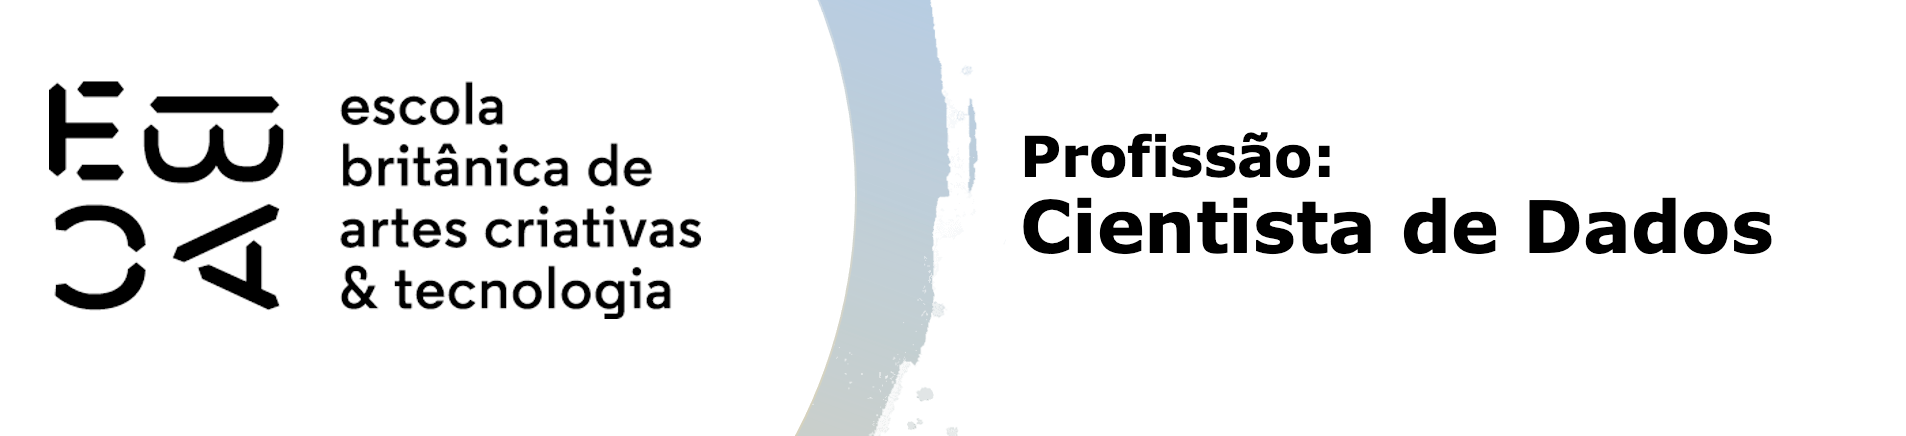

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [29]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Data acquisition and database connection

# Statistical analysis
from scipy import stats
import pickle

#sklearn
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
from sklearn import metrics
from scipy.stats import ks_2samp

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
def data_info(df):
    """
    Creates a summary DataFrame containing information about each column in the input DataFrame.
    
    Parameters:
        df (pandas.DataFrame): Input DataFrame to analyze
        
    Returns:
        pandas.DataFrame: A DataFrame with the following columns:
            - dtypes: Data type of each column
            - Missing: Number of missing values in each column
            - Unique: Number of unique values in each column
            - Example: First value from each column
            - Entropy: Shannon entropy of value distributions (in bits)
            
    Notes:
        - Prints the shape of the input DataFrame
        - Entropy is calculated using scipy.stats.entropy with base 2
        - Higher entropy values indicate more uniform distributions
    """
    info = pd.DataFrame({
        'dtypes': df.dtypes,
        'Missing': df.isna().sum(),
        'Unique': df.nunique(),
        'Example': df.iloc[0],
        'Entropy': [round(stats.entropy(df[col].value_counts(normalize=True), base=2), 2) 
                   for col in df.columns]
    })
    
    print(f"Dataset Shape: {df.shape}")
    return info

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df['data_mes'] = df.data_ref.dt.to_period('M')


df_train = df[df.data_ref.dt.to_period('M') <= df.data_ref.dt.to_period('M').max()-3].drop(columns=['data_ref','index'])
df_oot = df[df.data_ref.dt.to_period('M') > df.data_ref.dt.to_period('M').max()-3].drop(columns=['data_ref','index'])
df = df.drop(columns=['data_ref','index'])



## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
print(f'Número de linhas para cada mês selecionados na amostra:\n{df.data_mes.value_counts()}')

Número de linhas para cada mês selecionados na amostra:
data_mes
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64


In [6]:
data_info(df)

Dataset Shape: (750000, 14)


,dtypes,Missing,Unique,Example,Entropy
sexo,object,0,2,F,0.91
posse_de_veiculo,object,0,2,N,0.96
posse_de_imovel,object,0,2,N,0.91
qtd_filhos,int64,0,8,0,1.25
tipo_renda,object,0,5,Empresário,1.72
educacao,object,0,5,Médio,1.16
estado_civil,object,0,5,Solteiro,1.44
tipo_residencia,object,0,6,Casa,0.66
idade,int64,0,47,43,5.39
tempo_emprego,float64,125957,3004,6.873973,11.06


In [7]:
# Separando variáveis qualitativas e quantitativas
vars_qualitativas = df.select_dtypes(include=['object']).columns
vars_quantitativas = df.select_dtypes(include=['int64', 'float64']).columns

# Análise descritiva para variáveis qualitativas
print("=== Análise das Variáveis Qualitativas ===")
for coluna in vars_qualitativas:
    print(f"\nVariável: {coluna}")
    print(df[coluna].value_counts())
    print("\nPercentual:")
    print(df[coluna].value_counts(normalize=True).round(3) * 100, "%")

# Análise descritiva para variáveis quantitativas
print("\n\n=== Análise das Variáveis Quantitativas ===")
print("\nEstatísticas Básicas:")
print(df[vars_quantitativas].describe().round(2))

# Métricas adicionais para variáveis quantitativas
print("\nAssimetria e Curtose:")
for coluna in vars_quantitativas:
    print(f"\nVariável: {coluna}")
    print(f"Assimetria: {df[coluna].skew().round(3)}")
    print(f"Curtose: {df[coluna].kurtosis().round(3)}")

=== Análise das Variáveis Qualitativas ===

Variável: sexo
sexo
F    504580
M    245420
Name: count, dtype: int64

Percentual:
sexo
F    67.3
M    32.7
Name: proportion, dtype: float64 %

Variável: posse_de_veiculo
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Percentual:
posse_de_veiculo
N    61.1
S    38.9
Name: proportion, dtype: float64 %

Variável: posse_de_imovel
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Percentual:
posse_de_imovel
S    67.2
N    32.8
Name: proportion, dtype: float64 %

Variável: tipo_renda
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

Percentual:
tipo_renda
Assalariado         51.4
Empresário          23.0
Pensionista         16.8
Servidor público     8.7
Bolsista             0.0
Name: proportion, dtype: float64 %

Variável: educacao
educacao
Médio                  506836
Superior completo  

In [8]:
qualitativa = df.select_dtypes(include=['object']).columns
quantitativa = df.select_dtypes(include=['number']).columns

<Figure size 1200x600 with 0 Axes>

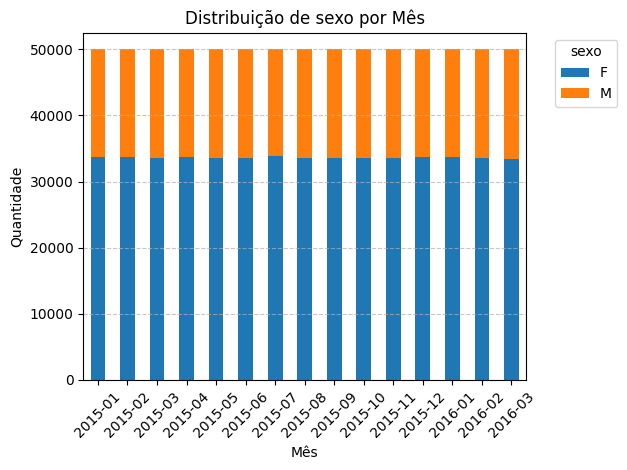

<Figure size 1200x600 with 0 Axes>

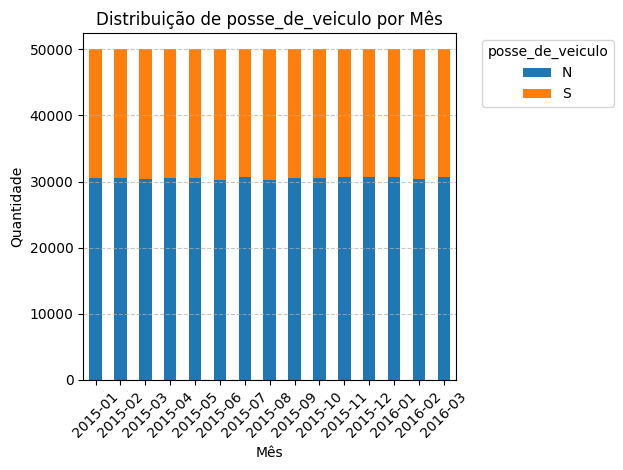

<Figure size 1200x600 with 0 Axes>

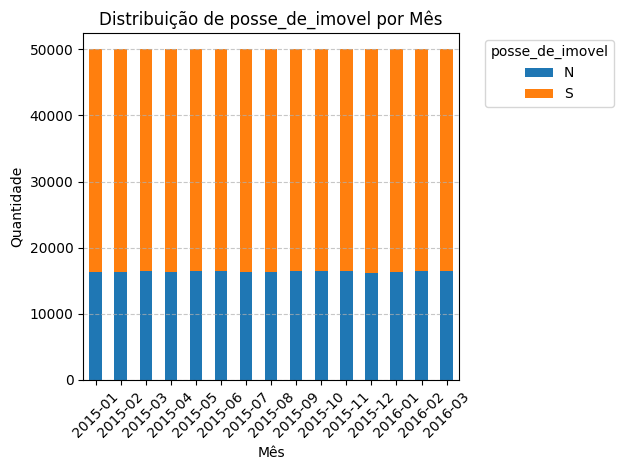

<Figure size 1200x600 with 0 Axes>

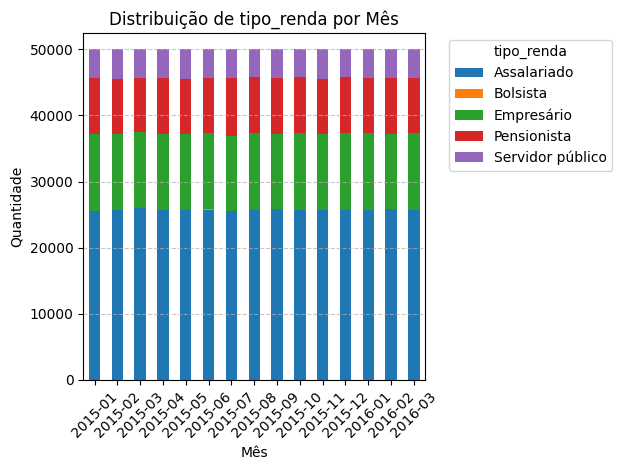

<Figure size 1200x600 with 0 Axes>

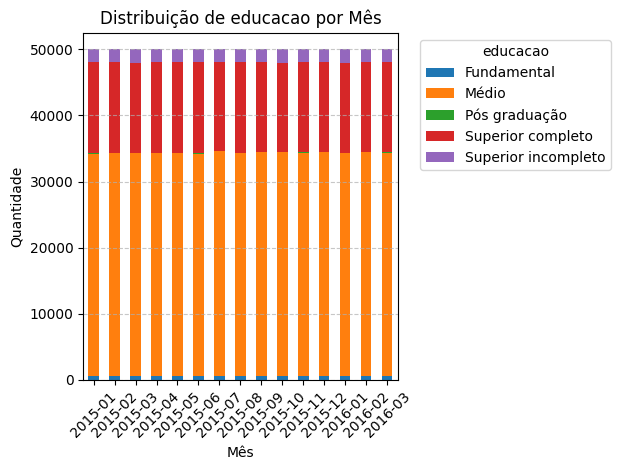

<Figure size 1200x600 with 0 Axes>

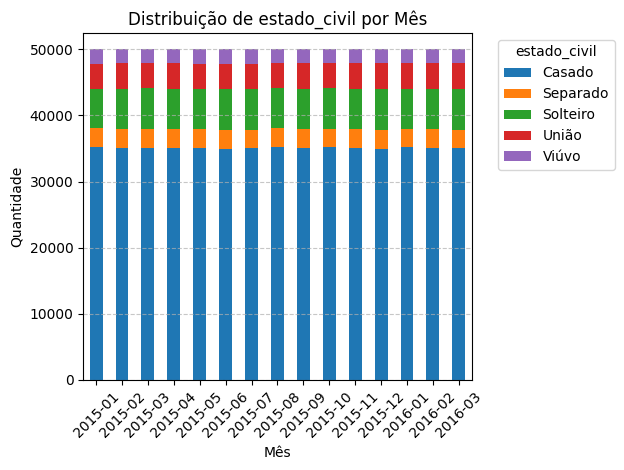

<Figure size 1200x600 with 0 Axes>

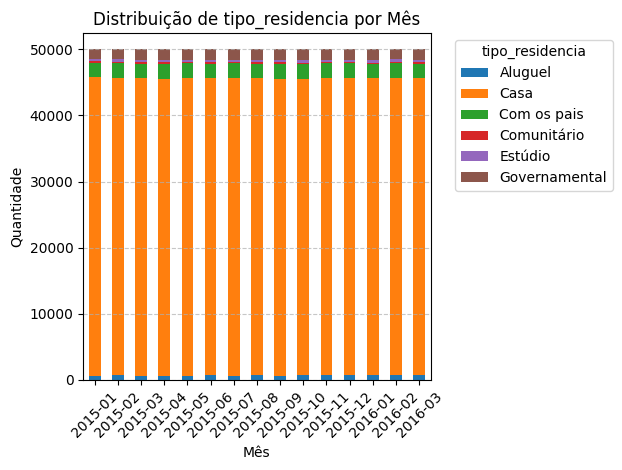

In [9]:
def plot_distribuicao_temporal(df, var_categorica):

    # Validação do tipo da variável
    if df[var_categorica].dtype != 'object':
        raise ValueError(f"A variável {var_categorica} não é do tipo object/categórica")
    
    try:
        # Criando o DataFrame com os dados agrupados
        grouped_data = df.groupby(['data_mes', var_categorica]).size().unstack()
        
        # Criando o gráfico
        plt.figure(figsize=(12, 6))
        ax = grouped_data.plot(kind='bar', stacked=True)
        
        # Personalizando o gráfico
        plt.title(f'Distribuição de {var_categorica} por Mês')
        plt.xlabel('Mês')
        plt.ylabel('Quantidade')
        plt.legend(title=var_categorica, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        

        
        # Ajustando o layout
        plt.tight_layout()
        
        # Mostrando o gráfico
        plt.show()
        
    except Exception as e:
        raise e

# Para todas as variáveis categóricas do DataFrame
vars_categoricas = df.select_dtypes(include=['object']).columns
for var in vars_categoricas:
    plot_distribuicao_temporal(df, var)

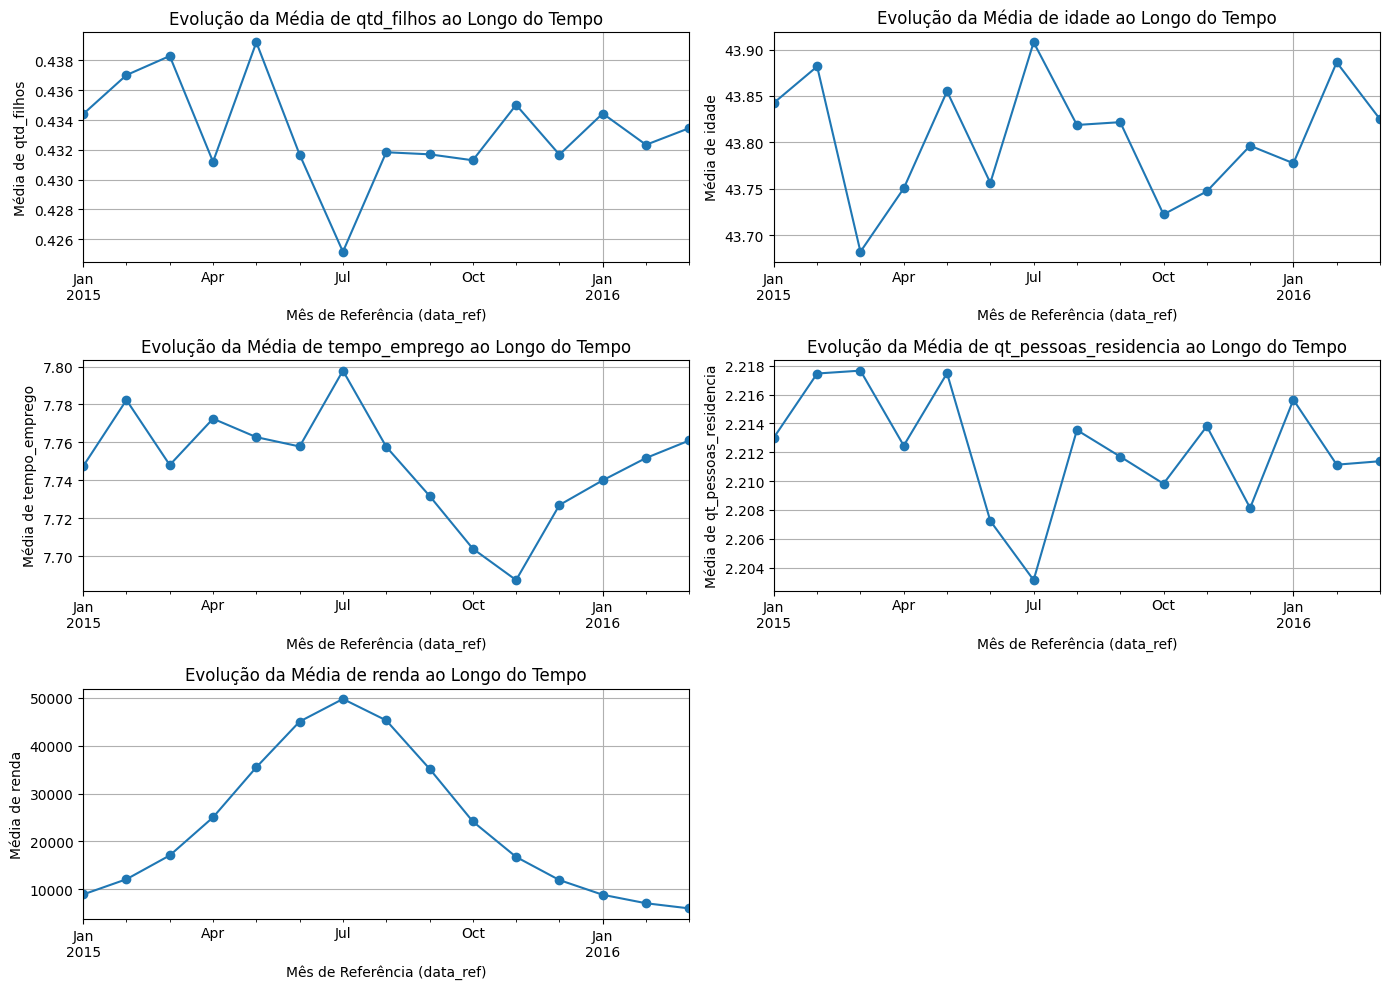

In [10]:
# Configuração dos subplots: 2 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2 linhas para acomodar 4 gráficos, e 2 colunas

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativa):
    df.groupby('data_mes')[var].mean().plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Evolução da Média de {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel(f'Média de {var}')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

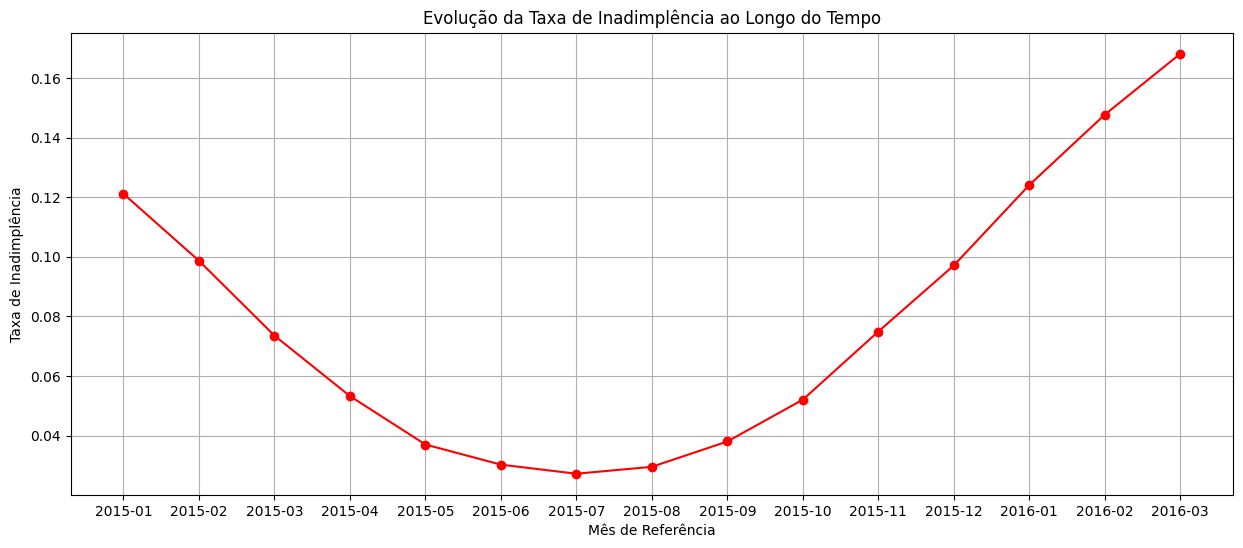

In [11]:

inadimplencia_por_mes = df.groupby('data_mes')['mau'].mean()

plt.figure(figsize=(15, 6))
plt.plot((inadimplencia_por_mes.index).astype(str), inadimplencia_por_mes.values, marker='o', color='red')
plt.title('Evolução da Taxa de Inadimplência ao Longo do Tempo')
plt.xlabel('Mês de Referência')
plt.ylabel('Taxa de Inadimplência')
plt.grid(True)
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

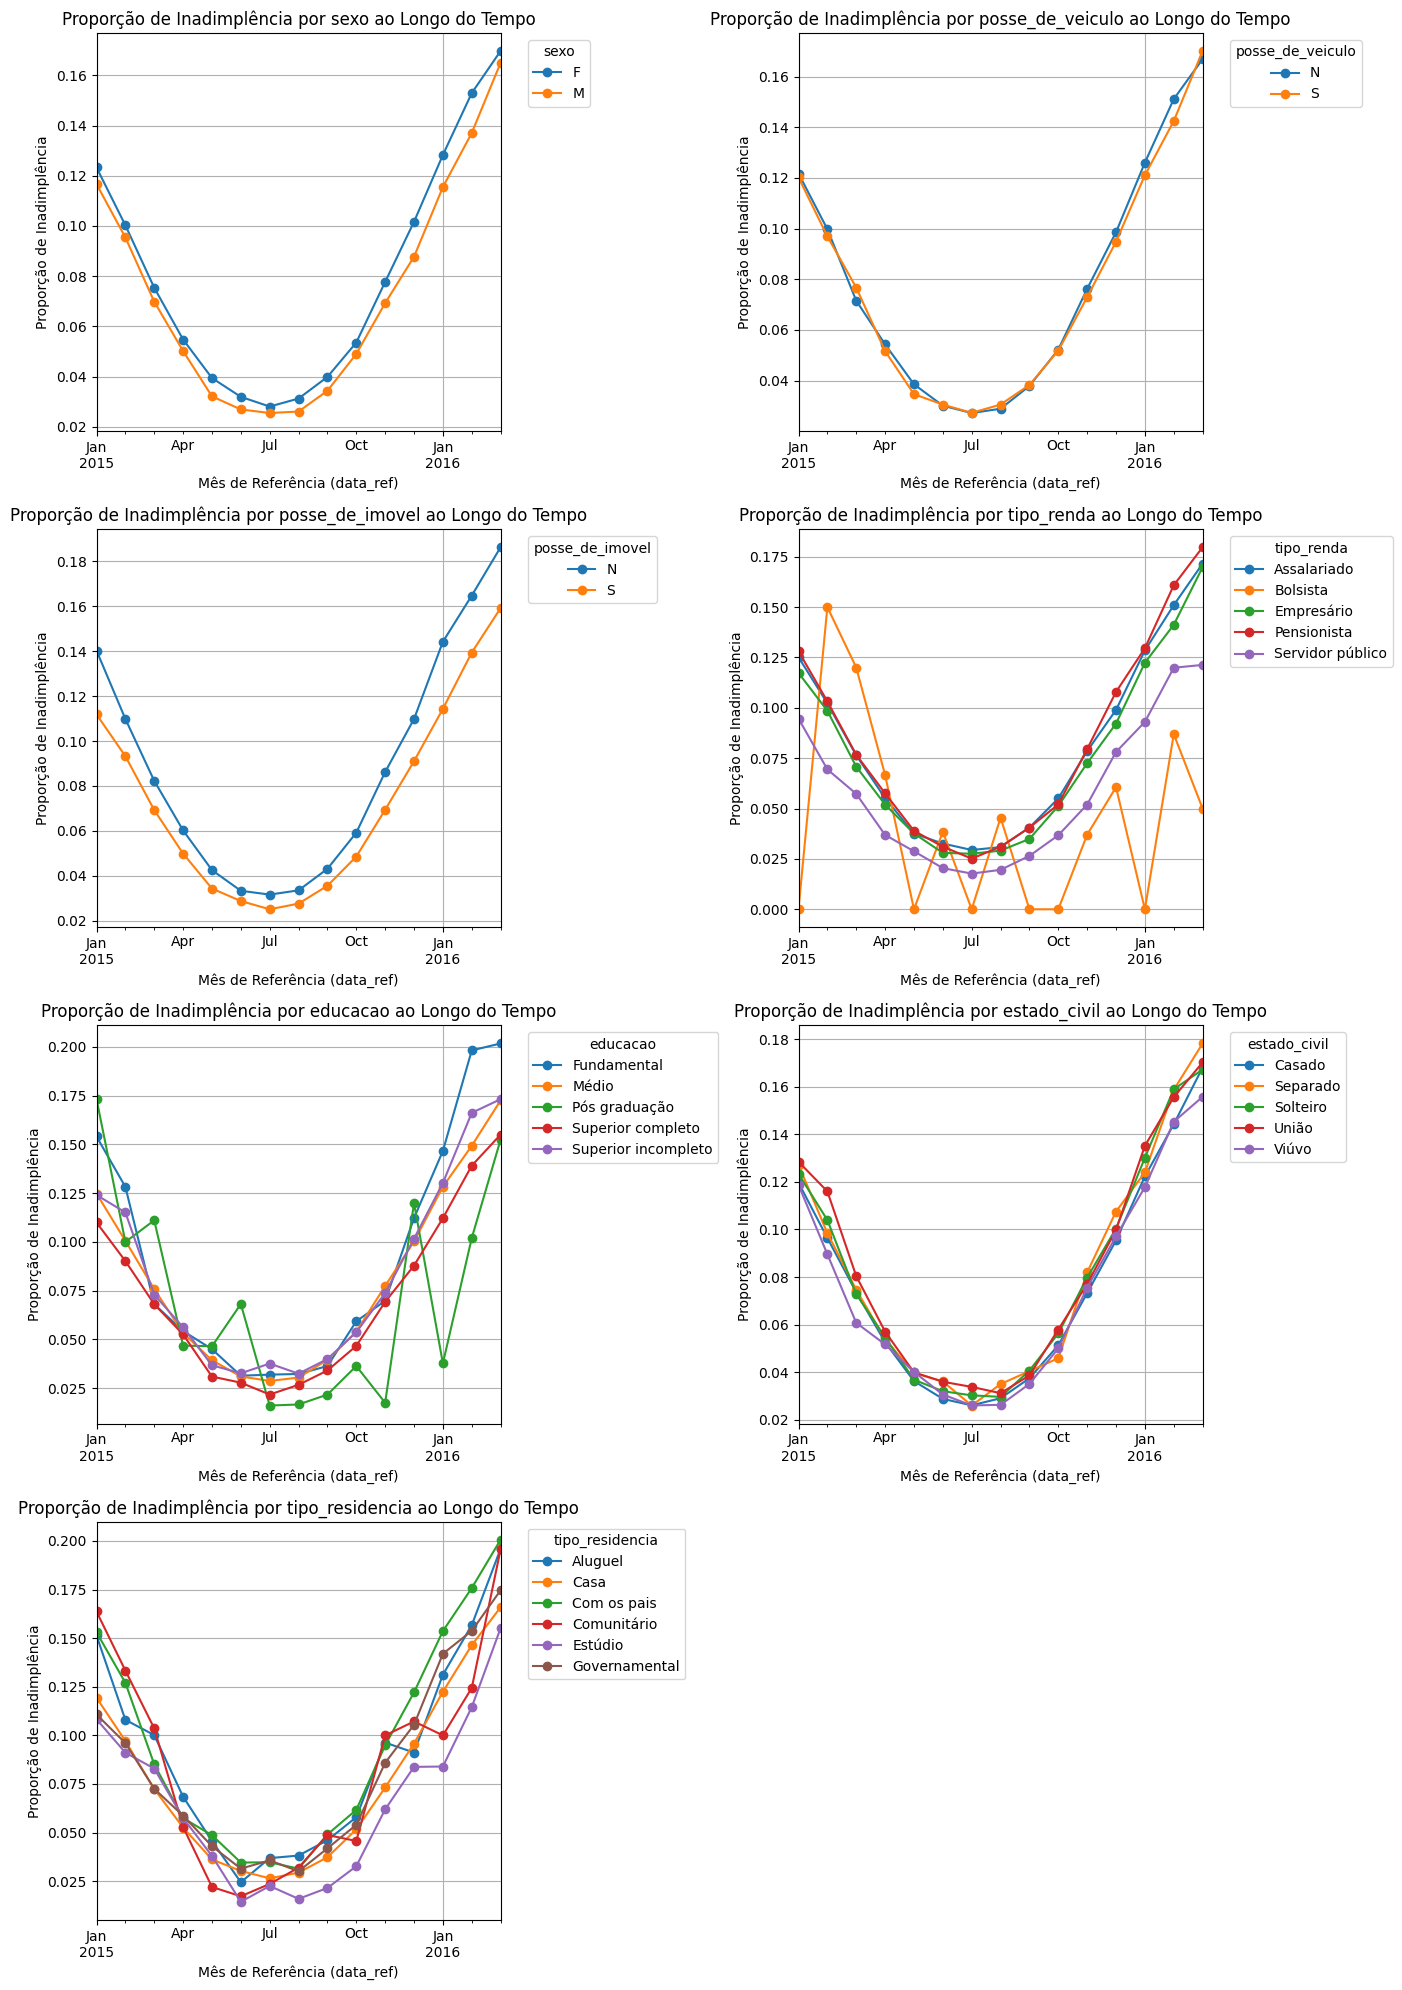

In [12]:
# Configuração dos subplots: 4 linhas e 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # Tamanho ajustado para melhor visualização

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(qualitativa):
    # Calcular a proporção de inadimplência por data_ref e variável qualitativa
    data = df.groupby(['data_mes', var])['mau'].mean().unstack()
    
    # Plotar o gráfico
    data.plot(marker='o', linestyle='-', ax=axes[i])
    
    # Configurações do gráfico
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True)

# Remover o último subplot vazio se houver número ímpar de gráficos
if len(qualitativa) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

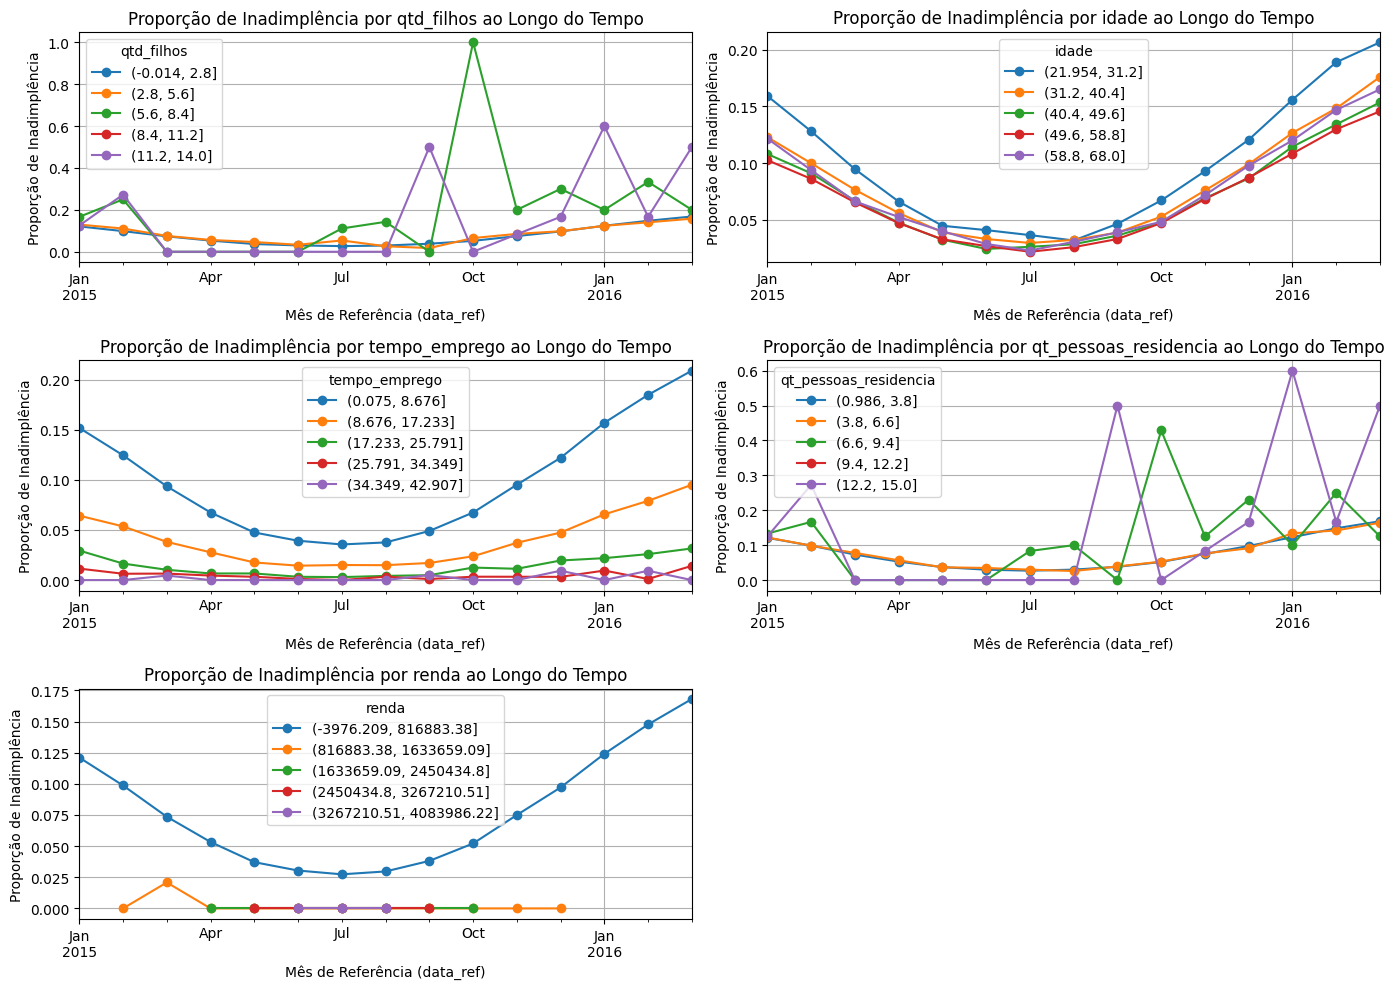

In [13]:

# Configuração dos subplots: 2 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2 linhas para acomodar 5 gráficos, e 2 colunas

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativa):
    # Calcular a proporção de inadimplência por faixas da variável quantitativa ao longo do tempo
    data = df.groupby(['data_mes', pd.cut(df[var], bins=5)], observed=False)['mau'].mean().unstack()
    data.plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [14]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
data_info(df)

Dataset Shape: (750000, 14)


,dtypes,Missing,Unique,Example,Entropy
sexo,object,0,2,F,0.91
posse_de_veiculo,object,0,2,N,0.96
posse_de_imovel,object,0,2,N,0.91
qtd_filhos,int64,0,8,0,1.25
tipo_renda,object,0,5,Empresário,1.72
educacao,object,0,5,Médio,1.16
estado_civil,object,0,5,Solteiro,1.44
tipo_residencia,object,0,6,Casa,0.66
idade,int64,0,47,43,5.39
tempo_emprego,float64,0,3005,6.873973,9.86


- tratando outliers usando IQR

In [15]:
df.select_dtypes(include=['number']).describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,750000.0,0.433251,0.739379,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,750000.0,7.748574,6.100107,0.117808,3.635616,7.473973,9.090411,4.290685e+01
qt_pessoas_residencia,750000.0,2.212241,0.903428,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,750000.0,23238.544747,79106.013795,107.670000,3467.700000,7861.820000,18318.280000,4.083986e+06


In [16]:

# Cria uma cópia do dataframe
df_limpo = df.copy()

# Obtém colunas numéricas
colunas_numericas = df.select_dtypes(include=['number']).columns

# Aplica o método IQR para cada coluna numérica
for coluna in colunas_numericas:
    # Calcula Q1, Q3 e IQR
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcula os limites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Substitui outliers pelos limites
    df_limpo[coluna] = df_limpo[coluna].clip(lower=limite_inferior, upper=limite_superior)

df_limpo[colunas_numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,750000.0,0.423100,0.692714,0.000000,0.000000,0.000000,1.000000,2.500000
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,68.000000
tempo_emprego,750000.0,7.247569,4.663740,0.117808,3.635616,7.473973,9.090411,17.272603
qt_pessoas_residencia,750000.0,2.202521,0.865866,1.000000,2.000000,2.000000,3.000000,4.500000
renda,750000.0,13035.214824,12665.605731,107.670000,3467.700000,7861.820000,18318.280000,40594.150000


- Preparando variáveis numéricas para agrupamento

In [17]:
scaler = StandardScaler()
df_limpo[colunas_numericas] = scaler.fit_transform(df_limpo[colunas_numericas])
df_number_pad = scaler.fit_transform(df_limpo[colunas_numericas])

In [18]:
SQD = []
K = range(1, 15)
for k in tqdm(K):
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(df_number_pad)
    SQD.append(km.inertia_)

  0%|          | 0/14 [00:00<?, ?it/s]

In [19]:
SQD

[3750000.00000001,
 2879358.381373885,
 1803897.4938856056,
 1632892.9398901672,
 1219297.890890228,
 1099239.82366944,
 1002765.1882905231,
 919270.2963407768,
 875472.1372455284,
 819812.1522209115,
 754252.9692660013,
 713508.9742721299,
 672790.4484524218,
 637105.5633228715]

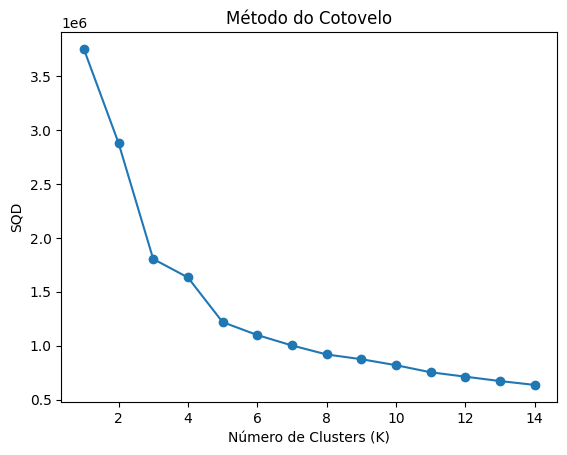

In [20]:
plt.plot(range(1, 15), SQD, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('SQD')
plt.title('Método do Cotovelo')
plt.show()

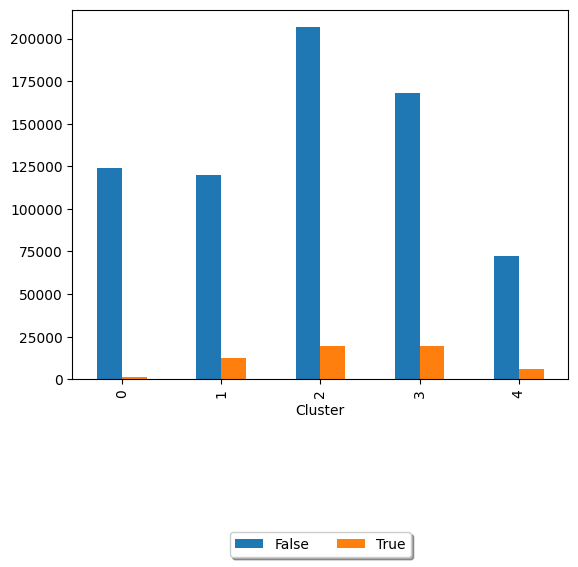

In [21]:
k = 5  # Escolha do número de clusters baseado no método do cotovelo
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df_number_pad)  # Obtendo os rótulos dos clusters

# Adicionar os rótulos ao dataframe (se houver)
df_limpo['Cluster'] = labels
ax = df_limpo.groupby(['Cluster', 'mau'],observed=True)['mau'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

In [22]:
data_info(df_limpo)

Dataset Shape: (750000, 15)


,dtypes,Missing,Unique,Example,Entropy
sexo,object,0,2,F,0.91
posse_de_veiculo,object,0,2,N,0.96
posse_de_imovel,object,0,2,N,0.91
qtd_filhos,float64,0,4,-0.610787,1.24
tipo_renda,object,0,5,Empresário,1.72
educacao,object,0,5,Médio,1.16
estado_civil,object,0,5,Solteiro,1.44
tipo_residencia,object,0,6,Casa,0.66
idade,float64,0,47,-0.07166,5.39
tempo_emprego,float64,0,2582,-0.080107,9.22


In [23]:
X_train = df_limpo[df_limpo.data_mes <= df_limpo.data_mes.max()-3].drop(columns=['data_mes','mau'])
X_teste = df_limpo[df_limpo.data_mes > df_limpo.data_mes.max()-3].drop(columns=['data_mes','mau'])

y_train = df_limpo[df_limpo.data_mes <= df_limpo.data_mes.max()-3]['mau']
y_teste = df_limpo[df_limpo.data_mes > df_limpo.data_mes.max()-3]['mau']

X_train.shape, X_teste.shape, y_train.shape, y_teste.shape

((600000, 13), (150000, 13), (600000,), (150000,))

In [24]:
X_train_dummy = pd.get_dummies(X_train, drop_first=False)
X_teste_dummy = pd.get_dummies(X_teste, drop_first=False)
X_train_dummy.shape, X_teste_dummy.shape, X_train.shape, X_teste.shape

((600000, 33), (150000, 33), (600000, 13), (150000, 13))

In [25]:
from sklearn.linear_model import LogisticRegression


# Ajustando o modelo de Regressão Logística com class_weight='balanced'
model = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=66)
model.fit(X_train_dummy, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, random_state=66)

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [26]:
# Fazendo predições
y_pred = model.predict(X_teste_dummy)
y_pred_proba = model.predict_proba(X_teste_dummy)[:, 1]

# Calculando Acurácia
acuracia = metrics.accuracy_score(y_teste, y_pred)

# Calculando AUC e GINI
fpr, tpr, thresholds = metrics.roc_curve(y_teste, y_pred_proba)
auc = metrics.auc(fpr, tpr)
gini = 2 * auc - 1

# Calculando KS
ks = ks_2samp(y_pred_proba[y_teste == 1], y_pred_proba[y_teste == 0]).statistic

# Imprimindo resultados
print('Métricas de Performance do Modelo base [out of time]:')
print('-' * 30)
print(f'Acurácia: {acuracia:.2%}')
print(f'KS:       {ks:.2%}')
print(f'GINI:     {gini:.2%}')
print(f'AUC:      {auc:.2%}\n\n')

# Fazendo predições
y_pred = model.predict(X_train_dummy)
y_pred_proba = model.predict_proba(X_train_dummy)[:, 1]

# Calculando Acurácia
acuracia = metrics.accuracy_score(y_train, y_pred)

# Calculando AUC e GINI
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_proba)
auc = metrics.auc(fpr, tpr)
gini = 2 * auc - 1

# Calculando KS
ks = ks_2samp(y_pred_proba[y_train == 1], y_pred_proba[y_train == 0]).statistic
print('Métricas de Performance do Modelo base [desenvolvimento]:')
print('-' * 30)
print(f'Acurácia: {acuracia:.2%}')
print(f'KS:       {ks:.2%}')
print(f'GINI:     {gini:.2%}')
print(f'AUC:      {auc:.2%}')


Métricas de Performance do Modelo base [out of time]:
------------------------------
Acurácia: 30.45%
KS:       32.75%
GINI:     44.53%
AUC:      72.26%


Métricas de Performance do Modelo base [desenvolvimento]:
------------------------------
Acurácia: 56.83%
KS:       39.49%
GINI:     53.11%
AUC:      76.56%


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

- Utilizando novamente a base original.

In [18]:
df = pd.read_feather('credit_scoring.ftr')
X_train = df[df.data_ref.dt.to_period('M') <= df.data_ref.dt.to_period('M').max()-3].drop(columns=['data_ref','index'])
X_teste = df[df.data_ref.dt.to_period('M') > df.data_ref.dt.to_period('M').max()-3].drop(columns=['data_ref','index'])
y_train = X_train['mau']
y_teste = X_teste['mau']



### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

- Variáveis numéricas substituir pela média
- Variáveis categóricas realiza um drop dos nulos

In [3]:
class CustomMissingHandler(BaseEstimator, TransformerMixin):
    """
    Transformer para tratamento de valores ausentes:
    - Colunas numéricas: imputa com média
    - Colunas categóricas: remove linhas com valores ausentes
    """
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.numeric_imputer = SimpleImputer(strategy='mean')
        self.numeric_columns_ = None
        self.object_columns_ = None
    
    def fit(self, X, y=None):
        """
        Identifica colunas e ajusta o imputador para colunas numéricas
        """
        X = pd.DataFrame(X)
        
        # Armazena nomes das colunas por tipo
        self.numeric_columns_ = X.select_dtypes(include=['number']).columns.tolist()
        self.object_columns_ = X.select_dtypes(include=['object']).columns.tolist()
        
        # Ajusta o imputador nas colunas numéricas
        if self.numeric_columns_:
            self.numeric_imputer.fit(X[self.numeric_columns_])
            
        if self.verbose:
            print(f"Colunas numéricas: {self.numeric_columns_}")
            print(f"Colunas categóricas: {self.object_columns_}")
        
        return self
    
    def transform(self, X):
        """
        Aplica a transformação nos dados
        """
        X = pd.DataFrame(X).copy()
        
        # Primeiro remove linhas com valores ausentes em colunas categóricas
        if self.object_columns_:
            X.dropna(subset=self.object_columns_, inplace=True)
        
        # Depois imputa valores nas colunas numéricas
        if self.numeric_columns_:
            X_numeric_imputed = self.numeric_imputer.transform(X[self.numeric_columns_])
            X[self.numeric_columns_] = X_numeric_imputed
        
        return X
    
    def get_feature_names_out(self, feature_names=None):
        """
        Retorna os nomes das features após transformação
        """
        if feature_names is None:
            feature_names = self.numeric_columns_ + self.object_columns_
        return feature_names


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

- Usarei o método de IQR para tratar outliers

In [4]:



class IQRTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, factor=1.5):
        self.factor = factor
        self.limits_ = {}
    
    def fit(self, X, y=None):

        # Garantir que X seja DataFrame
        X = pd.DataFrame(X)
        
        # Selecionar apenas colunas numéricas
        numeric_cols = X.select_dtypes(include=['number']).columns
        
        for column in numeric_cols:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            
            self.limits_[column] = {
                'lower': Q1 - (self.factor * IQR),
                'upper': Q3 + (self.factor * IQR)
            }
        
        return self
    
    def transform(self, X):

        # Criar cópia para não modificar os dados originais
        X = pd.DataFrame(X).copy()
        
        # Aplicar limites apenas nas colunas numéricas que foram ajustadas no fit
        for column in self.limits_.keys():
            if column in X.columns:
                X[column] = X[column].clip(
                    lower=self.limits_[column]['lower'],
                    upper=self.limits_[column]['upper']
                )
        
        return X
    
    def get_feature_names_out(self, feature_names=None):

        if feature_names is None:
            feature_names = list(self.limits_.keys())
        return feature_names

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [16]:
class VariableSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=8):
        self.n_features = n_features
        self.selected_columns_ = None
        self.feature_importances_ = None
        self.preprocessor_ = None
        
    def fit(self, X, y):
        # Garantir que X é um DataFrame
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Identificar colunas numéricas e dummy
        numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
        dummy_cols = X.select_dtypes(include=['uint8', 'bool']).columns
        
        # Criar preprocessador
        transformers = []
        if len(numeric_cols) > 0:
            transformers.append(('num', StandardScaler(), numeric_cols))
        if len(dummy_cols) > 0:
            transformers.append(('dummy', 'passthrough', dummy_cols))
            
        self.preprocessor_ = ColumnTransformer(
            transformers,
            remainder='drop',
            sparse_threshold=0
        )
        
        # Preparar os dados
        X_prepared = self.preprocessor_.fit_transform(X)
        
        # Obter nomes das features após transformação
        feature_names = (
            list(numeric_cols) +
            list(dummy_cols)
        )
        
        # Treinar o modelo
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        model.fit(X_prepared, y)
        
        # Armazenar importâncias e selecionar features
        self.feature_importances_ = model.feature_importances_
        indices = np.argsort(self.feature_importances_)[-self.n_features:]
        self.selected_columns_ = np.array(feature_names)[indices]
        
        print("Variáveis selecionadas:", self.selected_columns_)
        return self
        
    def transform(self, X):
        # Garantir que X é um DataFrame
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Aplicar o mesmo preprocessamento
        X_prepared = self.preprocessor_.transform(X)
        
        # Converter para DataFrame com os nomes das colunas originais
        feature_names = (
            list(X.select_dtypes(include=['int64', 'float64']).columns) +
            list(X.select_dtypes(include=['uint8', 'bool']).columns)
        )
        X_prepared_df = pd.DataFrame(X_prepared, columns=feature_names, index=X.index)
        
        # Retornar apenas as colunas selecionadas
        return X_prepared_df[self.selected_columns_]
    
    def get_feature_names_out(self, feature_names=None):
        return self.selected_columns_

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [6]:
# Define a PCA to Linear dimensionality reduction
pca = PCA(n_components=5)


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [7]:
class DummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [20]:
pipe = Pipeline(steps=[
    ('missing', CustomMissingHandler()),
    ('iqr', IQRTransformer()),
    ('dummie', DummiesTransformer()),
    ('selector', VariableSelector()),
    ('scaler', StandardScaler()),
    ('pca', pca)
])

pipe.fit(X_train,y_train)




Variáveis selecionadas: ['posse_de_imovel_S' 'posse_de_imovel_N' 'qtd_filhos'
 'qt_pessoas_residencia' 'idade' 'tempo_emprego' 'renda' 'mau']


Pipeline(steps=[('missing', CustomMissingHandler()), ('iqr', IQRTransformer()),
                ('dummie', DummiesTransformer()),
                ('selector', VariableSelector()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=5))])

In [24]:
X_train_pipe = pd.DataFrame(pipe.transform(X_train))

### Treinar um modelo de regressão logistica com o resultado

In [28]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_pipe, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

### Salvar o pickle file do modelo treinado

In [30]:
nome_arquivo = 'model_final_pipe.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [31]:
df = pd.read_feather('credit_scoring.ftr').drop(columns=['data_ref','index'])
df = df.sample(50000)

In [32]:
from pycaret.classification import *


clf1 = setup(data=df, target='mau', session_id=123)


models()

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(50000, 13)"
4,Transformed data shape,"(50000, 30)"
5,Transformed train set shape,"(35000, 30)"
6,Transformed test set shape,"(15000, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.6%


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [33]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9217,0.7677,0.0433,0.5714,0.0805,0.0702,0.1417
1,0.9214,0.7733,0.0397,0.5500,0.0741,0.0641,0.1322
2,0.9203,0.7814,0.0253,0.4375,0.0478,0.0395,0.0900
3,0.9226,0.7727,0.0361,0.7143,0.0687,0.0616,0.1491
4,0.9209,0.7930,0.0217,0.5000,0.0415,0.0352,0.0914
5,0.9171,0.7455,0.0144,0.2000,0.0268,0.0164,0.0338
6,0.9191,0.7632,0.0540,0.4286,0.0958,0.0795,0.1298
7,0.9197,0.7478,0.0396,0.4400,0.0726,0.0603,0.1131
8,0.9206,0.8067,0.0468,0.5000,0.0855,0.0729,0.1346


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9217,0.7709,0.0325,0.6000,0.0616,0.0540,0.1266
1,0.9217,0.7770,0.0433,0.5714,0.0805,0.0702,0.1417
2,0.9200,0.7912,0.0217,0.4000,0.0411,0.0332,0.0780
3,0.9223,0.7724,0.0289,0.7273,0.0556,0.0498,0.1348
4,0.9203,0.7986,0.0217,0.4286,0.0412,0.0339,0.0820
5,0.9191,0.7519,0.0108,0.2727,0.0208,0.0148,0.0401
6,0.9191,0.7730,0.0432,0.4138,0.0782,0.0641,0.1130
7,0.9226,0.7590,0.0432,0.7059,0.0814,0.0729,0.1619
8,0.9226,0.8194,0.0468,0.6842,0.0875,0.0782,0.1652


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


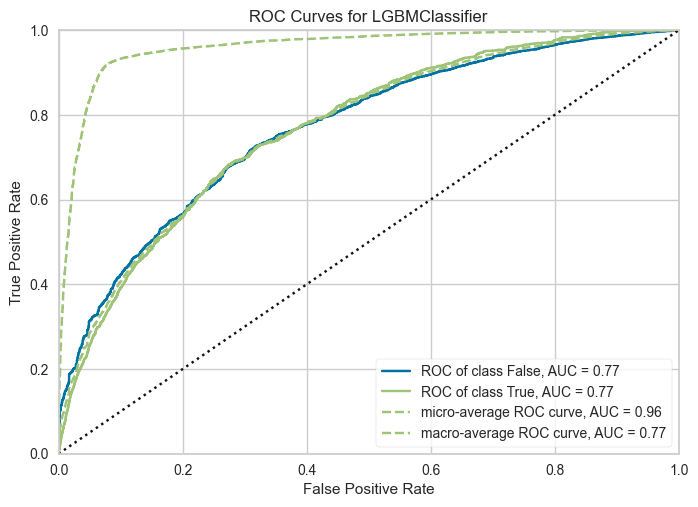

In [35]:
plot_model(tuned_lightgbm, plot='auc')

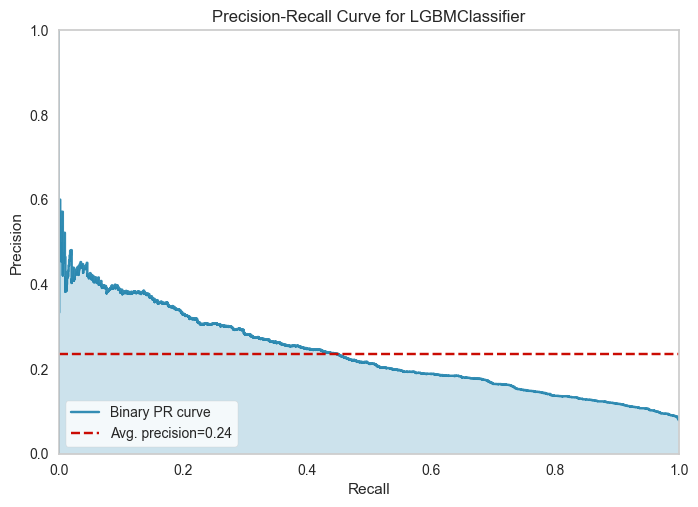

In [36]:
plot_model(tuned_lightgbm, plot = 'pr')

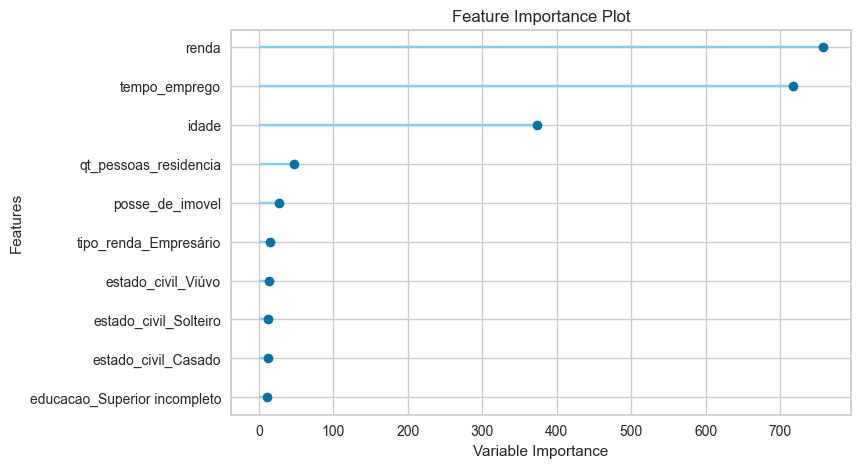

In [37]:
plot_model(tuned_lightgbm, plot='feature')

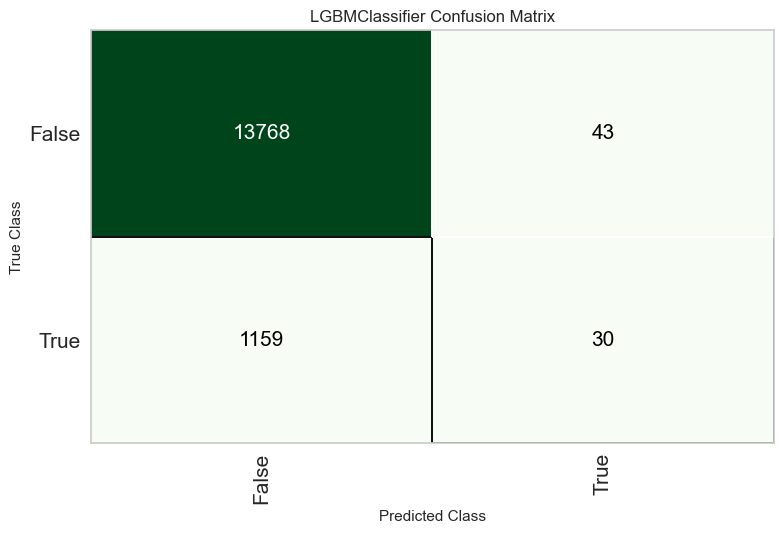

In [38]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [39]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [40]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9199,0.7686,0.0252,0.4110,0.0475,0.0387,0.0859


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
684250,M,S,N,1,Assalariado,Médio,Casado,Casa,35,5.290411,3.0,2489.080078,False,0,0.8338
164793,F,N,S,1,Assalariado,Médio,Casado,Casa,41,8.597260,3.0,6547.850098,False,0,0.9559
40819,F,N,S,0,Servidor público,Superior completo,Casado,Casa,51,12.189041,2.0,8704.799805,False,0,0.9010
285855,F,N,S,2,Empresário,Médio,Casado,Casa,29,1.972603,4.0,15153.339844,False,0,0.9808
695185,F,N,N,1,Empresário,Médio,Separado,Casa,41,21.860273,2.0,8143.609863,False,0,0.9396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511016,F,N,N,0,Assalariado,Superior completo,União,Casa,28,6.183562,2.0,14817.839844,False,0,0.9785
243087,M,S,N,1,Servidor público,Médio,Casado,Casa,30,9.687672,3.0,2821.760010,False,0,0.8568
545427,F,N,N,0,Assalariado,Médio,Casado,Casa,31,3.517808,2.0,1892.880005,False,0,0.8421
534081,F,N,S,0,Empresário,Superior completo,Casado,Casa,33,3.630137,2.0,2040.329956,True,0,0.8183


In [41]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [42]:
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [43]:
predict_model(final_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9209,0.7977,0.0244,0.5179,0.0466,0.0397,0.0994


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [45]:
save_model(final_lightgbm,'Final_LightGBM_Model_20250315')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

### Salvar o arquivo do modelo treinado

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.